# Library

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from analysis import *
from utils import *

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix

# Data

In [297]:
df = pd.read_csv(
    r'../../data/cleaned/clean3.csv',
    encoding='utf-8',
)

In [298]:
df.head()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,...,product_type,sku,customer_demographics,shipping_carriers,location,inspection_results,transportation_modes,routes,shipping_times_category,supplier_name
0,69.808006,55,802,8661.996792,58,7,96,4,2.956572,29,...,haircare,SKU0,Non-binary,Carrier B,Mumbai,Pending,Road,Route B,Standard,Supplier 3
1,14.843523,95,736,7460.900065,53,30,37,2,9.716575,23,...,skincare,SKU1,Female,Carrier A,Mumbai,Pending,Road,Route B,Express,Supplier 3
2,11.319683,34,8,9577.749626,1,10,88,2,8.054479,12,...,haircare,SKU2,Unknown,Carrier B,Mumbai,Pending,Air,Route C,Express,Supplier 1
3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,24,...,skincare,SKU3,Non-binary,Carrier C,Kolkata,Fail,Rail,Route A,Standard,Supplier 5
4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,5,...,skincare,SKU4,Non-binary,Carrier A,Delhi,Fail,Air,Route A,Economy,Supplier 1


# Load metadata

In [299]:
df = load_metadata(
    df,
    r"../../data/metadata/metadata3.json",
)

# Overview

## Check

In [300]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 25
Num of rows: 100


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   price                    100 non-null    float64 
 1   availability             100 non-null    int64   
 2   number_of_products_sold  100 non-null    int64   
 3   revenue_generated        100 non-null    float64 
 4   stock_levels             100 non-null    int64   
 5   lead_times               100 non-null    int64   
 6   order_quantities         100 non-null    int64   
 7   shipping_times           100 non-null    int64   
 8   shipping_costs           100 non-null    float64 
 9   lead_time                100 non-null    int64   
 10  production_volumes       100 non-null    int64   
 11  manufacturing_lead_time  100 non-null    int64   
 12  manufacturing_costs      100 non-null    float64 
 13  defect_rates             100 non-null    float64 
 14  costs      

In [302]:
df.isnull().sum()

price                      0
availability               0
number_of_products_sold    0
revenue_generated          0
stock_levels               0
lead_times                 0
order_quantities           0
shipping_times             0
shipping_costs             0
lead_time                  0
production_volumes         0
manufacturing_lead_time    0
manufacturing_costs        0
defect_rates               0
costs                      0
product_type               0
sku                        0
customer_demographics      0
shipping_carriers          0
location                   0
inspection_results         0
transportation_modes       0
routes                     0
shipping_times_category    0
supplier_name              0
dtype: int64

## Varibles and target

In [303]:
target = ['supplier_name']
variablies = [col for col in df.columns if col not in target]

print(target)
print(variablies)

['supplier_name']
['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs', 'product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']


# Grouping Varibles by their respective data types

In [304]:
numerical_cols, categorical_cols, _ = group_columns_by_type(df, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 10
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category', 'supplier_name']



# Multivariate

In [305]:
df_numerical = df[numerical_cols].copy()
df_categorical = df[categorical_cols].copy()

In [306]:
encoder = OrdinalEncoder(
    categories=[["Supplier 1", "Supplier 2", "Supplier 3", "Supplier 4", "Supplier 5"]]
)
df["supplier_name"] = encoder.fit_transform(df[["supplier_name"]])
df["supplier_name"].unique()

array([2., 0., 4., 3., 1.])

## Visualization and dimensionality reduction

### PCA

In [307]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerical)

#### Selection `n_components`

In [308]:
n_components_pca_full = min(df_numerical.shape[0], df_numerical.shape[1])

In [309]:
pca_full = PCA(n_components=n_components_pca_full, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

In [310]:
explained_var = pca_full.explained_variance_ratio_
eigenvalues = pca_full.explained_variance_
cum_var = np.cumsum(explained_var)

summary_df = pd.DataFrame(
        {
            "eigenvalue": eigenvalues,
            "variance_%": explained_var * 100,
            "variance_(cumulative)_%": cum_var * 100,
        }
    )

summary_df.index = [f"PC{i+1}" for i in range(len(explained_var))]
summary_df.round(2)

,eigenvalue,variance_%,variance_(cumulative)_%
PC1,1.68,11.07,11.07
PC2,1.49,9.85,20.92
PC3,1.48,9.75,30.67
PC4,1.38,9.11,39.78
PC5,1.21,8.00,47.77
PC6,1.20,7.89,55.67
PC7,1.04,6.88,62.55
PC8,0.99,6.56,69.11
PC9,0.94,6.21,75.32
PC10,0.83,5.47,80.79


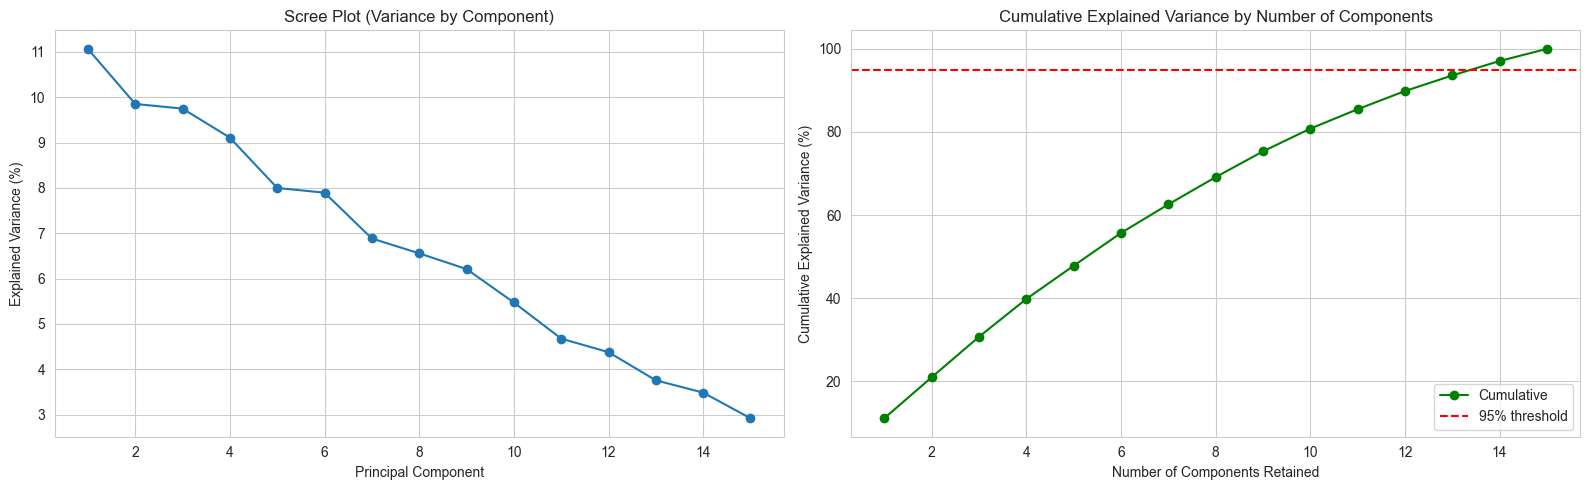

In [311]:
plot_pca_contributions(pca_full, 0.95)

#### Main

In [312]:
pca = PCA(n_components=13, random_state=42)
X_pca = pca.fit(X_scaled)

In [313]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[-5.44959167e-01, -3.91226341e-01, -2.04777675e-01,
        -2.32361210e-01, -1.72039626e-01,  2.75405594e-01,
        -3.94632748e-02,  1.12273814e-01, -3.74049423e-01,
         1.60277186e-01, -1.49660764e-01, -7.85893170e-02,
        -1.37794648e-01],
       [-3.38233190e-02,  5.82607365e-01,  1.80394110e-01,
        -1.90287235e-01, -2.71351130e-01,  2.34258747e-01,
         5.33776195e-02,  8.59324785e-03, -4.88988025e-01,
        -2.38647496e-01, -3.03334747e-01, -8.92178837e-03,
         1.54339852e-01],
       [ 1.25170694e-01, -9.89961263e-02,  2.31011375e-01,
        -1.35689702e-01, -4.21952455e-01,  6.03630577e-01,
         6.29523232e-02, -1.57358335e-01,  2.80609349e-01,
        -3.00163653e-01,  3.78228474e-01, -5.41594516e-02,
         5.35261684e-02],
       [-1.44724813e-01, -1.12643125e-01, -3.47492650e-01,
         6.03200852e-01, -2.66417977e-01,  6.16108851e-02,
        -5.10201144e-02, -3.12325028e-01,  3.72820224e-02,
        -1.98076315e-01, -2.08742898e

In [314]:
get_pca_contribution_table(
    pca,
    variable_names=numerical_cols,
    percent=True
)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
price,17.71 %,10.25 %,2.84 %,3.91 %,2.44 %,6.34 %,0.15 %,1.27 %,14.87 %,3.1 %,3.16 %,0.93 %,3.34 %
availability,0.07 %,22.74 %,2.2 %,2.62 %,6.08 %,4.59 %,0.27 %,0.01 %,25.41 %,6.87 %,12.99 %,0.01 %,4.19 %
number_of_products_sold,0.93 %,0.66 %,3.61 %,1.33 %,14.69 %,30.46 %,0.38 %,2.49 %,8.37 %,10.87 %,20.19 %,0.44 %,0.5 %
revenue_generated,1.25 %,0.85 %,8.17 %,26.37 %,5.86 %,0.32 %,0.25 %,9.82 %,0.15 %,4.73 %,6.15 %,31.13 %,2.53 %
stock_levels,0.34 %,4.18 %,3.25 %,12.66 %,9.19 %,12.49 %,21.72 %,2.67 %,0.65 %,1.8 %,0.01 %,8.88 %,21.32 %
lead_times,7.12 %,13.21 %,3.72 %,8.73 %,3.01 %,3.74 %,0.91 %,8.32 %,3.44 %,15.78 %,1.11 %,3.38 %,14.75 %
order_quantities,3.79 %,15.0 %,5.12 %,0.01 %,0.03 %,13.46 %,4.3 %,0.76 %,0.16 %,35.13 %,10.55 %,4.93 %,0.1 %
shipping_times,0.24 %,1.17 %,2.61 %,0.03 %,11.17 %,22.74 %,2.31 %,30.74 %,8.3 %,0.05 %,9.23 %,5.56 %,4.21 %
shipping_costs,0.03 %,3.25 %,0.0 %,4.5 %,17.44 %,3.29 %,35.17 %,12.35 %,0.17 %,7.73 %,3.19 %,0.31 %,7.54 %
lead_time,6.36 %,11.1 %,16.66 %,13.22 %,0.77 %,0.16 %,3.36 %,0.17 %,0.31 %,0.14 %,0.32 %,11.79 %,4.13 %


#### Report

---

**PC1**: Production & Cost Efficiency Component (11.07%)

**Biến chi phối**:
- `production_volumes` 24.45%
- `manufacturing_lead_time` 15.57%
- `defect_rates` 14.06%
- `costs` 7.65%
- `lead_times` 7.12%

**Diễn giải**:
- Đại diện cho hiệu suất sản xuất tổng thể: khối lượng, tốc độ, lỗi và chi phí.
- Các nhà cung cấp có điểm PC1 cao nghĩa là có **năng lực sản xuất lớn, ít lỗi, chi phí hợp lý**.

---

**PC2**: Operational & Availability Dynamics (9.85%)

**Biến chi phối**:
- `availability` 22.74%
- `order_quantities` 15.0%
- `lead_times` 13.21%
- `lead_time` 11.1%

**Diễn giải**:
- Biểu diễn mức độ sẵn hàng và linh hoạt trong đáp ứng đơn hàng.
- Điểm cao ở PC2 nghĩa là nhà cung cấp **phản ứng nhanh, hàng có sẵn, tốc độ dẫn đầu**.

---

**PC3**: Cost & Manufacturing Tradeoff (9.75%)

**Biến chi phối**:
- `manufacturing_costs` 25.34%
- `lead_time` 16.66%
- `defect_rates` 11.23%
- `costs` 10.21%

**Diễn giải**:
- Phản ánh tác động giữa chi phí sản xuất, lỗi và thời gian sản xuất.
- PC3 cao nghĩa là **chi phí cao nhưng có thể chất lượng và năng lực tốt**.

---

**PC4**: Revenue & Quality Component (9.11%)

**Biến chi phối**:
- `revenue_generated` 26.37%
- `stock_levels` 12.66%
- `lead_time` 13.22%
- `defect_rates` 8.18%

**Diễn giải**:
- Diễn tả khả năng sinh lợi gắn với chất lượng sản phẩm và tồn kho tối ưu.
- Điểm cao nghĩa là **doanh thu tốt, chất lượng sản phẩm cao, quản lý tồn kho hiệu quả**.

---

**PC5**: Price & Cost Ratio (8.00%)

**Biến chi phối**:
- `shipping_costs` 17.44%
- `production_volumes` 16.51%
- `defect_rates` 10.89%

**Diễn giải**:
- Phản ánh hiệu suất giá – chi phí vận hành.
- Điểm cao nghĩa là **giá bán hợp lý, chi phí thấp, năng suất cao**.

---

**PC6**: Sales & Supply Chain Responsiveness (7.89%)

**Biến chi phối**:
- `number_of_products_sold` 30.46%
- `shipping_times` 22.74%
- `stock_levels` 12.49%

**Diễn giải**:
- Thể hiện sự kết nối giữa bán hàng và hiệu quả vận chuyển.
- Điểm cao nghĩa là **bán nhanh, giao hàng nhanh, tồn kho hợp lý**.

---

**Các PC phụ (PC7–PC10)**:

- **PC7**: Chiến lược chi phí vận chuyển (`Shipping cost strategy`)
- **PC8**: Tối ưu hóa thời gian vận chuyển (`Shipping time optimization`)
- **PC9**: Chi phí vận tải và đơn hàng (`Transportation cost and orders`)
- **PC10**: Đáp ứng đơn hàng và dự báo nhu cầu (`Order fulfillment and demand forecasting`)

---

### MCA

In [315]:
df_categorical.columns

Index(['product_type', 'sku', 'customer_demographics', 'shipping_carriers',
       'location', 'inspection_results', 'transportation_modes', 'routes',
       'shipping_times_category', 'supplier_name'],
      dtype='object')

In [316]:
df_categorical_mca = df_categorical.drop(columns=['supplier_name']).copy()

#### Select `n_components`

In [317]:
n_components_mca_full = min(df_categorical_mca.shape[0], df_categorical_mca.shape[1])

mca_full = MCA(
    n_components=n_components_mca_full, 
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
    one_hot=True
).fit(df_categorical)

In [318]:
mca_full.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.292,2.37%,2.37%
1,0.284,2.31%,4.68%
2,0.274,2.23%,6.91%
3,0.256,2.08%,9.00%
4,0.249,2.02%,11.02%
5,0.236,1.92%,12.94%
6,0.232,1.89%,14.83%
7,0.220,1.79%,16.62%
8,0.213,1.73%,18.35%


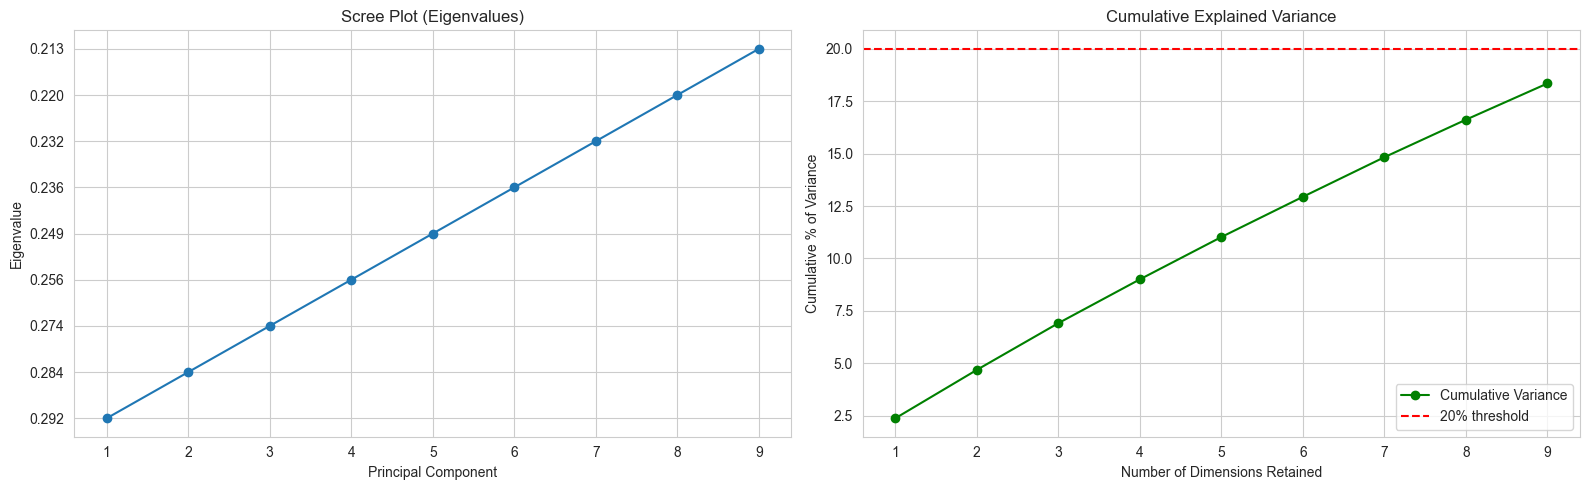

In [319]:
plot_mca_contributions(mca_full, 0.20)

#### Main

In [320]:
mca = MCA(
        n_components=n_components_mca_full ,
        n_iter=10,
        copy=True,
        check_input=True,
        engine="sklearn",
        random_state=42,
        one_hot=True,
    )
mca = mca.fit(df_categorical_mca)

In [321]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.309,2.34%,2.34%
1,0.293,2.22%,4.55%
2,0.288,2.17%,6.73%
3,0.271,2.05%,8.78%
4,0.259,1.96%,10.74%
5,0.255,1.93%,12.67%
6,0.239,1.81%,14.48%
7,0.237,1.79%,16.27%
8,0.229,1.73%,18.00%


In [322]:
mca.plot(
    df_categorical_mca,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=False,
    show_column_labels=False,
    show_row_labels=False,
)

alt.LayerChart(...)

In [323]:
mca.column_contributions_.head()

,0,1,2,3,4,5,6,7,8
product_type__cosmetics,0.047294,0.029633,0.001103,0.007390,0.019146,0.012419,0.029045,0.023625,0.009538
product_type__haircare,0.058514,0.007561,0.006548,0.021967,0.001264,0.020777,0.042330,0.009963,0.013695
product_type__skincare,0.002274,0.047940,0.010278,0.004535,0.006206,0.001853,0.002734,0.046633,0.034831
sku__SKU0,0.008385,0.001915,0.002394,0.000152,0.000401,0.003948,0.003403,0.002370,0.001303
sku__SKU1,0.000491,0.008783,0.001411,0.000284,0.001489,0.000231,0.034673,0.002208,0.000834


In [324]:
get_mca_contribution_table(mca, percent=True)

,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9
product_type,10.81 %,8.51 %,1.79 %,3.39 %,2.66 %,3.5 %,7.41 %,8.02 %,5.81 %
sku,35.97 %,37.91 %,38.64 %,40.93 %,42.87 %,43.62 %,46.4 %,46.86 %,48.61 %
customer_demographics,9.16 %,9.43 %,8.5 %,11.98 %,6.38 %,11.45 %,3.69 %,2.18 %,12.45 %
shipping_carriers,13.97 %,5.99 %,5.54 %,1.04 %,8.23 %,6.44 %,7.68 %,0.19 %,1.02 %
location,9.49 %,5.47 %,8.51 %,10.95 %,11.63 %,17.31 %,10.92 %,22.06 %,15.61 %
inspection_results,7.94 %,6.88 %,4.68 %,8.08 %,3.93 %,5.29 %,12.55 %,1.85 %,0.26 %
transportation_modes,8.27 %,11.48 %,12.01 %,8.56 %,11.83 %,5.22 %,1.48 %,14.67 %,9.69 %
routes,0.83 %,2.78 %,11.54 %,5.6 %,12.01 %,4.0 %,7.87 %,3.91 %,2.54 %
shipping_times_category,3.56 %,11.54 %,8.79 %,9.48 %,0.46 %,3.15 %,2.0 %,0.26 %,4.01 %
Total,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %


#### Report

**Dim1**: Product–Distribution Interaction Component (10.81%)

**Biến chi phối**:
* sku 35.97%
* shipping_carriers 13.97%
* location 9.49%
* product_type 10.81%

**Diễn giải**:
* Thành phần này thể hiện mối liên kết giữa danh mục sản phẩm, hãng vận chuyển và khu vực phân phối.
* Các đối tượng có điểm Dim1 cao đại diện cho sản phẩm **phân phối rộng, liên kết mạnh với các kênh vận chuyển đa dạng**.

---

**Dim2**: Transportation & Delivery Efficiency Component (8.51%)

**Biến chi phối**:
* sku 37.91%
* transportation_modes 11.48%
* shipping_times_category 11.54%
* customer_demographics 9.43%
* 
**Diễn giải**:
* Thành phần này phản ánh hiệu quả vận tải và tốc độ giao hàng theo từng loại sản phẩm (SKU).
* Điểm Dim2 cao biểu thị đơn vị có **hệ thống vận chuyển linh hoạt và thời gian giao hàng tối ưu**.

---

**Dim3**: Routing & Logistics Optimization Component (1.79%)

**Biến chi phối**:
* sku 38.64%
* transportation_modes 12.01%
* routes 11.54%
* shipping_times_category 8.79%

**Diễn giải**:
* Thành phần này mô tả sự phối hợp giữa loại hàng hóa, tuyến đường và phương thức vận tải.
* Điểm Dim3 cao phản ánh khả năng **tối ưu hóa tuyến và phương tiện để nâng cao hiệu suất giao hàng**.

---

**Dim4**: Market–Customer Alignment Component (3.39%)

**Biến chi phối**:
* sku 40.93%
* customer_demographics 11.98%
* location 10.95%
* inspection_results 8.08%

**Diễn giải**:
* Đại diện cho mối liên hệ giữa đặc điểm khách hàng, vị trí địa lý và dòng sản phẩm.
* Điểm Dim4 cao cho thấy sản phẩm **phù hợp đặc thù khách hàng và khu vực mục tiêu**.

---

**Dim5**: Transportation Route Strategy Component (2.66%)

**Biến chi phối**:
* sku 42.87%
* routes 12.01%
* transportation_modes 11.83%
* location 11.63%

**Diễn giải**:
* Thành phần này nhấn mạnh chiến lược lựa chọn tuyến đường và phương tiện vận tải cho từng SKU.
* Điểm Dim5 cao phản ánh sự **đa dạng chiến lược vận chuyển và khả năng thích ứng theo khu vực**.

---

**Dim6**: Product–Regional Distribution Component (3.50%)

**Biến chi phối**:
* sku 43.62%
* location 17.31%
* customer_demographics 11.45%

**Diễn giải**:
* Phản ánh mối tương quan giữa sản phẩm và khu vực phân phối, cùng ảnh hưởng nhân khẩu học.
* Điểm Dim6 cao đại diện cho danh mục sản phẩm được **phân bổ theo từng vùng tiêu thụ rõ rệt**.

---

**Dim7**: Quality & Inspection Component (7.41%)

**Biến chi phối**:
* sku 46.40%
* inspection_results 12.55%
* product_type 7.41%

**Diễn giải**:
* Thành phần này thể hiện chất lượng kiểm định và độ ổn định sản phẩm theo danh mục SKU.
* Điểm Dim7 cao biểu thị sản phẩm có **kiểm định tốt, độ tin cậy và chất lượng cao**.

---

**Dim8**: Regional SKU Segmentation Component (8.02%)

**Biến chi phối**:
* sku 46.86%
* location 22.06%
* transportation_modes 14.67%

**Diễn giải**:
* Đại diện cho phân khúc sản phẩm theo vùng địa lý, có liên quan đến phương thức vận chuyển.
* Điểm Dim8 cao cho thấy **phân bổ sản phẩm đặc trưng theo vùng, được hỗ trợ bởi kênh vận chuyển phù hợp**.

---

**Dim9**: Customer–Geographic Preference Component (5.81%)

**Biến chi phối**:
* sku 48.61%
* customer_demographics 12.45%
* location 15.61%

**Diễn giải**:
* Thành phần này mô tả mối liên hệ giữa nhân khẩu học khách hàng, vùng tiêu thụ và danh mục sản phẩm.
* Điểm Dim9 cao phản ánh **phân khúc khách hàng cụ thể có xu hướng lựa chọn sản phẩm đặc trưng theo vùng**.

## Clustering

### Preprocessing

In [325]:
X = df.drop(columns=['supplier_name']).copy()
y = df[['supplier_name']].copy()

print(X.shape)
print(y.shape)

(100, 24)
(100, 1)


In [326]:
num_cols, cat_cols, _ = group_columns_by_type(X, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 9
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']



#### Numerical

In [327]:
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#### Categorical

In [328]:
ord_cols = []
nol_cols = [col for col in cat_cols if col not in ord_cols]

print("Ordinal columns:", ord_cols)
print("Nominal columns:", nol_cols)

Ordinal columns: []
Nominal columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']


In [329]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_nol = encoder.fit_transform(X[nol_cols])
X_nol = pd.DataFrame(
    X_nol,
    columns=encoder.get_feature_names_out(nol_cols)
)
X = pd.concat([X, X_nol], axis=1)
X.drop(columns=nol_cols, inplace=True)

### Kmeans


#### Pick `k` by Silhouette score

In [330]:
best_score = -1
best_k = None
scores = []

for k in range(2, 11):  # thử từ 2 đến 10 cụm
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    try:
        score = silhouette_score(X, labels)
        scores.append((k, score))
        if score > best_score:
            best_score = score
            best_k = k
    except:
        continue

print(f"Best k = {best_k} with Silhouette Score = {best_score:.3f}")

Best k = 2 with Silhouette Score = 0.047


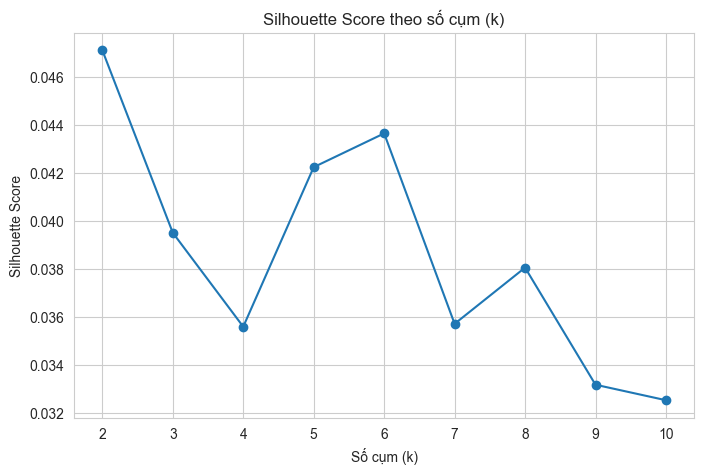

In [331]:
ks, sil_scores = zip(*scores)

plt.figure(figsize=(8, 5))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score theo số cụm (k)")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Model

In [332]:
model = KMeans(n_clusters=best_k)
model.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [333]:
labels = model.predict(X)
df['cluster'] = labels

#### Visualization

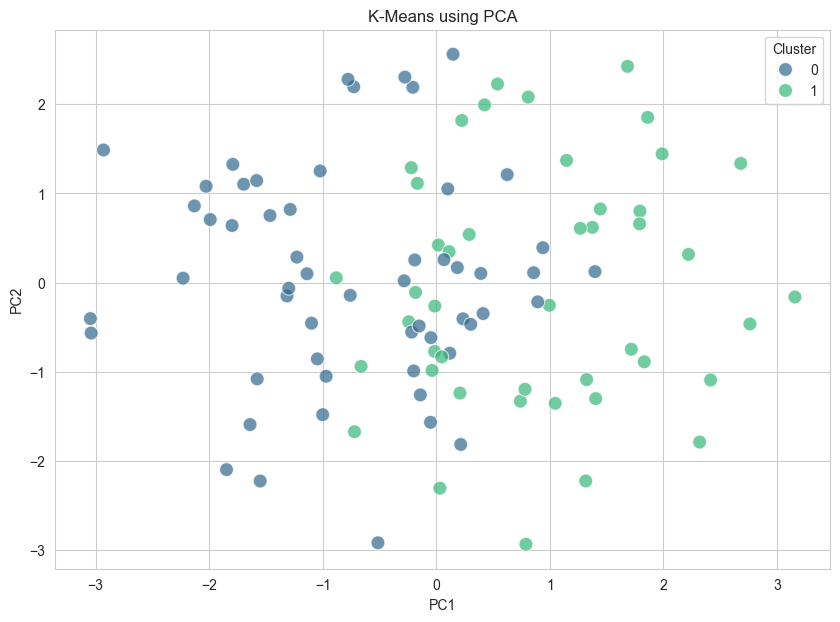

In [334]:
# Sử dụng PCA để giảm xuống 2D cho visualization
pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X)

# Tạo DataFrame cho visualization
df_viz = pd.DataFrame(
    X_pca_viz,
    columns=['PC1', 'PC2']
)
df_viz['Cluster'] = labels
df_viz['Supplier'] = df['supplier_name'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_viz,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title("K-Means using PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

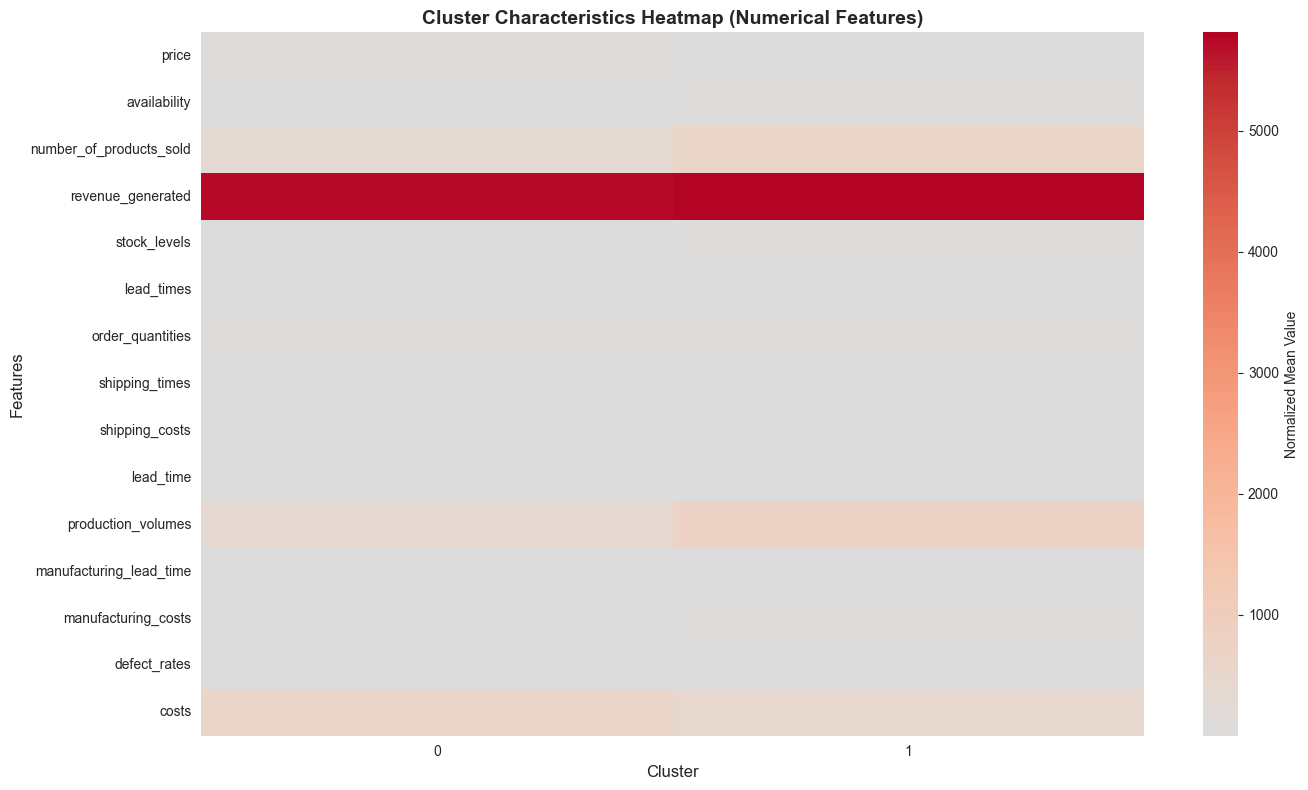


Cluster Sizes:
cluster
0    55
1    45
Name: count, dtype: int64


In [335]:
# Phân tích đặc trưng của từng cluster
cluster_summary = df.groupby('cluster')[num_cols].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(
    cluster_summary.T,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt='.2f',
    cbar_kws={'label': 'Normalized Mean Value'}
)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Cluster Characteristics Heatmap (Numerical Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCluster Sizes:")
print(df['cluster'].value_counts().sort_index())

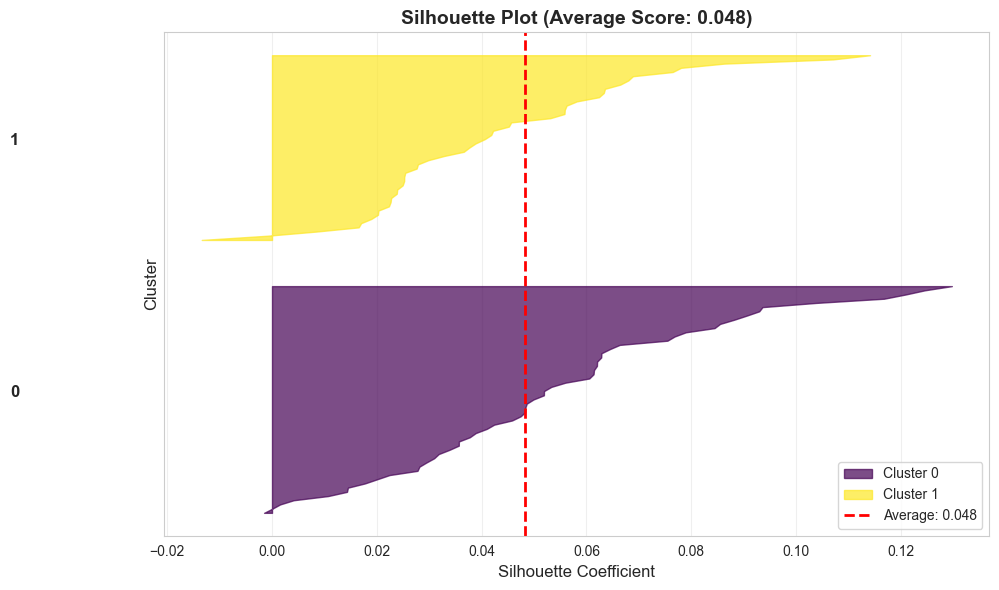

In [336]:
# Silhouette plot cho từng cluster
silhouette_vals = silhouette_samples(X, labels)
silhouette_avg = silhouette_score(X, labels)

fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

for i in range(best_k):
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        facecolor=colors[i],
        edgecolor=colors[i],
        alpha=0.7,
        label=f'Cluster {i}'
    )
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight='bold')
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title(f'Silhouette Plot (Average Score: {silhouette_avg:.3f})', fontsize=14, fontweight='bold')
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Average: {silhouette_avg:.3f}')
ax.set_yticks([])
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Outliers

In [337]:
outlier_list = []

In [338]:
df = cap_outliers_by_iqr(df, 'temperature', lower=-20, upper=50)
df = cap_outliers_by_iqr(df, 'wind_speed')
df = cap_outliers_by_iqr(df, 'visibility_(km)')

KeyError: 'temperature'

In [ ]:
df = cap_outliers_by_iqr(df, 'atmospheric_pressure', lower=950, upper=1050)
df = remove_outliers_by_iqr(df, 'atmospheric_pressure')

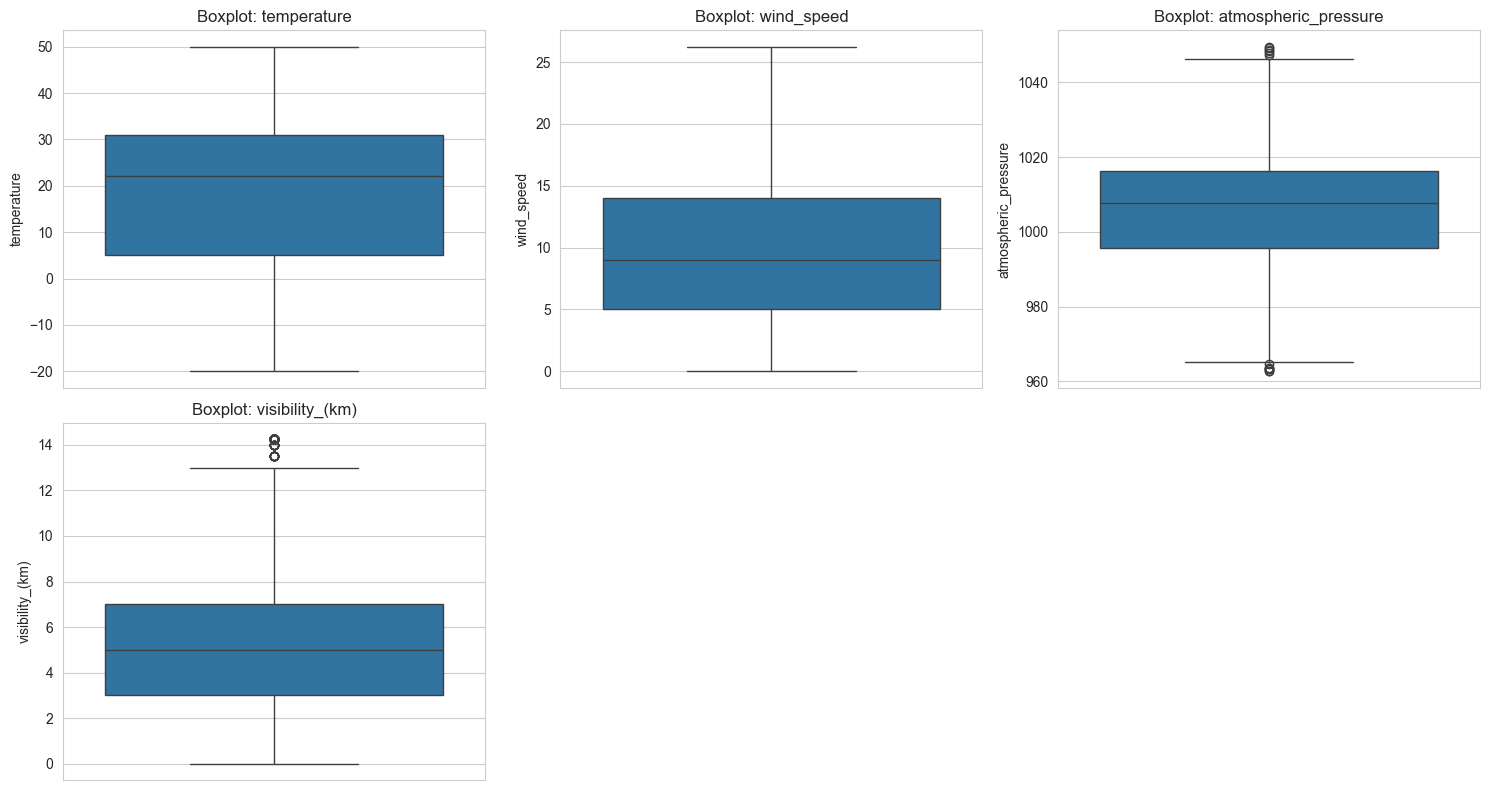

In [ ]:
plot_multiple_boxplots(df, outlier_list)

# Save

## Metadata `.json`

In [ ]:
save_metadata(
    df,
    r"../../data/metadata/metadata4.json",
)

## To `.csv`

In [ ]:
df.to_csv(
    r"../../data/cleaned/clean4.csv",
    index=False,
    encoding="utf-8",
)